# 1. Configuration and Data Generation

This cell handles the necessary imports, defines the experiment configuration (dimensions, vector count), and generates the normalized dummy data for Cosine distance comparison.

In [10]:
import numpy as np
import hnswlib
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# --- Global Configuration ---
DIM = 128               # Vector dimensionality
NUM_ELEMENTS = 50000    # Database size
NUM_QUERIES = 100       # Number of queries to test
TARGET_K = 1            # Target K for deep dive analysis (Recall@1)
K_VALUES = [1, 5, 10, 20, 50, 100] # K values for general benchmarking

# --- DATA GENERATION ---

def normalize(v):
    """Normalize vectors to unit length."""
    return v / np.linalg.norm(v, axis=1, keepdims=True)

print(f"🔄 Generating {NUM_ELEMENTS} random vectors...")

# Generate random float32 data
raw_data = np.random.random((NUM_ELEMENTS, DIM)).astype(np.float32)
raw_queries = np.random.random((NUM_QUERIES, DIM)).astype(np.float32)

# Normalize data for Cosine space
data = normalize(raw_data)
queries = normalize(raw_queries)

print("✅ Data generation and normalization complete!")

🔄 Generating 50000 random vectors...
✅ Data generation and normalization complete!


# 2. CELL 2: Core Functions & Establish Ground Truth

This cell defines the primary logic functions and runs Brute Force search to establish the Ground Truth (GT) and the fixed time baseline.

In [11]:
# --- CORE FUNCTIONS ---

def run_brute_force_cosine(dataset, query_vectors, k):
    """
    Executes exact Brute Force search (Ground Truth/Baseline).
    """
    start = time.perf_counter()
    # Calculate Cosine Distance: 1 - Dot Product (assuming normalized vectors)
    dists = 1 - np.dot(query_vectors, dataset.T)
    # Get top k indices with smallest distance
    indices = np.argsort(dists, axis=1)[:, :k]
    end = time.perf_counter()
    return indices, end - start

def calculate_recall(ground_truth, predicted):
    """
    Calculates average Recall@K.
    """
    total_recall = 0
    k = ground_truth.shape[1]
    num_queries = len(ground_truth)
    
    for i in range(num_queries):
        gt_set = set(ground_truth[i])
        pred_set = set(predicted[i])
        match_count = len(gt_set.intersection(pred_set))
        total_recall += match_count / k
    return total_recall / num_queries

# --- GROUND TRUTH CALCULATION ---

# GT for K=1 (Used for Deep Dive Recall calculation)
print("\n⏳ Running Brute Force to establish Ground Truth (K=1)...")
gt_indices_k1, bf_time_k1 = run_brute_force_cosine(data, queries, k=1)
bf_time_us = (bf_time_k1 / NUM_QUERIES) * 1_000_000 
print(f"✅ Ground Truth ready. Brute Force Avg Time (K=1): {bf_time_us:.2f} µs/query")

# GT for max K (Used for General Benchmark Recall)
max_k = max(K_VALUES)
print(f"\n⏳ Calculating Ground Truth for K={max_k}...")
gt_indices_max, _ = run_brute_force_cosine(data, queries, k=max_k)


⏳ Running Brute Force to establish Ground Truth (K=1)...
✅ Ground Truth ready. Brute Force Avg Time (K=1): 1458.73 µs/query

⏳ Calculating Ground Truth for K=100...


# 3. General Benchmark (Time & Recall vs K)

Runs the benchmark for varying K values. Brute Force timing is included inside the loop for direct, visual comparison on the plot.

In [12]:
# --- GENERAL BENCHMARK: Time & Recall vs K ---

# 1. Build HNSW Index (Standard Configuration)
print("\n🏗️ Building HNSW Index (M=40, efConst=200)...")
p = hnswlib.Index(space='cosine', dim=DIM)
p.init_index(max_elements=NUM_ELEMENTS, ef_construction=200, M=40)
p.add_items(data)
p.set_ef(100)
print("✅ Index built.")

# 2. Run benchmark loop & Measure Brute Force in parallel
results_k = {'k': [], 'hnsw_time': [], 'recall': [], 'bf_time': []}

print(f"\n🚀 Benchmark Results:")
print(f"{'K':<5} | {'HNSW Time (µs)':<15} | {'BF Time (µs)':<15} | {'Recall':<10}")
print("-" * 52)

for k in K_VALUES:
    # Measure HNSW time
    start_hnsw = time.perf_counter()
    hnsw_labels, _ = p.knn_query(queries, k=k)
    end_hnsw = time.perf_counter()
    avg_time_us_hnsw = ((end_hnsw - start_hnsw) / NUM_QUERIES) * 1_000_000
    
    # Measure Brute Force time in parallel (for visualization)
    _, bf_run_time_total = run_brute_force_cosine(data, queries, k=k)
    bf_run_time_avg_us = (bf_run_time_total / NUM_QUERIES) * 1_000_000
    
    # Calculate Recall
    current_gt = gt_indices_max[:, :k]
    recall = calculate_recall(current_gt, hnsw_labels)
    
    # Store results
    results_k['k'].append(k)
    results_k['hnsw_time'].append(avg_time_us_hnsw)
    results_k['bf_time'].append(bf_run_time_avg_us)
    results_k['recall'].append(recall)
    
    print(f"{k:<5} | {avg_time_us_hnsw:<15.2f} | {bf_run_time_avg_us:<15.2f} | {recall:.4f}")


🏗️ Building HNSW Index (M=40, efConst=200)...
✅ Index built.

🚀 Benchmark Results:
K     | HNSW Time (µs)  | BF Time (µs)    | Recall    
----------------------------------------------------
1     | 42.95           | 1432.21         | 0.8900
5     | 50.11           | 1354.02         | 0.8400
10    | 49.77           | 1357.78         | 0.8330
20    | 52.05           | 1381.91         | 0.8050
50    | 73.72           | 1434.37         | 0.7724
100   | 55.70           | 1390.85         | 0.7263


# 4. General Benchmark Visualization

Plots the speed (logarithmic axis) and accuracy (Recall@K) comparison vs K.

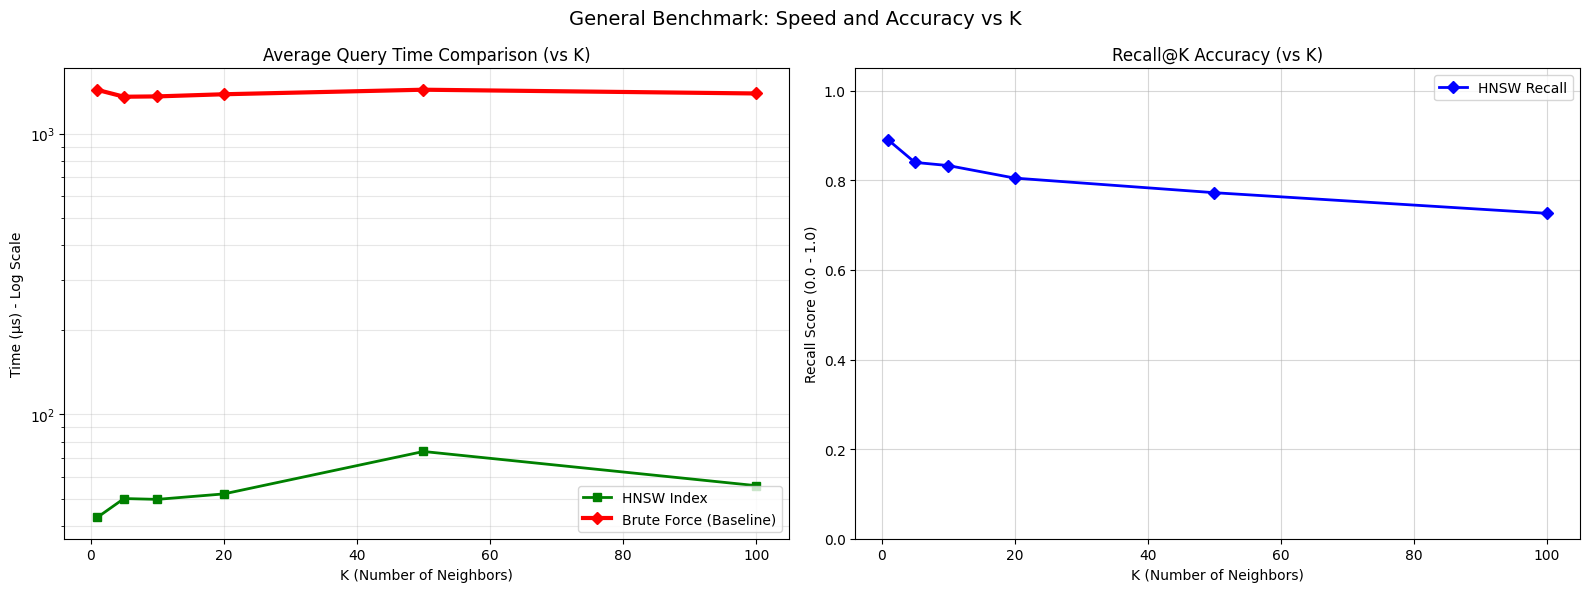

In [13]:
# --- PLOTTING: GENERAL BENCHMARK ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Time Comparison (Log Scale)
ax1.plot(results_k['k'], results_k['hnsw_time'], 'g-s', label='HNSW Index', linewidth=2)
# Brute Force is plotted as a calculated line
ax1.plot(results_k['k'], results_k['bf_time'], 'r-D', label='Brute Force (Baseline)', linewidth=3) 
ax1.set_title('Average Query Time Comparison (vs K)')
ax1.set_xlabel('K (Number of Neighbors)')
ax1.set_ylabel('Time (µs) - Log Scale')
ax1.set_yscale('log') 
ax1.grid(True, which="both", ls="-", alpha=0.3)
ax1.legend()

# Plot 2: Recall Accuracy
ax2.plot(results_k['k'], results_k['recall'], 'b-D', label='HNSW Recall', linewidth=2)
ax2.set_title('Recall@K Accuracy (vs K)')
ax2.set_xlabel('K (Number of Neighbors)')
ax2.set_ylabel('Recall Score (0.0 - 1.0)')
ax2.set_ylim(0, 1.05)
ax2.grid(True, alpha=0.5)
ax2.legend()

plt.suptitle("General Benchmark: Speed and Accuracy vs K", fontsize=14)
plt.tight_layout()
plt.show()

# 5. Parameter Tuning Experiment (Deep Dive)

Runs a detailed experiment to see how the construction parameters (M, efConstruction) and search parameter (efSearch) affect performance at K=1. Brute Force timing is included in the innermost loop.

In [14]:
# --- DEEP DIVE: PARAMETER TUNING EXPERIMENT ---

# Configuration
M_values = [4, 8, 16, 32, 64]           
efConst_values = [16, 64, 200]          
efSearch_values = [10, 20, 40, 80, 120, 160, 200, 300] 

experiment_results = {}

print("\n🚀 Starting Deep Dive Experiment (This may take a few minutes)...")
total_steps = len(efConst_values) * len(M_values)
step_count = 0

for efConst in efConst_values:
    experiment_results[efConst] = {}
    print(f"\n--- Testing efConstruction = {efConst} ---")
    
    for M in M_values:
        step_count += 1
        print(f"  [{step_count}/{total_steps}] Building Index M={M}...", end=" ")
        
        try:
            # 1. Build Index
            p = hnswlib.Index(space='cosine', dim=DIM)
            p.init_index(max_elements=NUM_ELEMENTS, ef_construction=efConst, M=M)
            p.add_items(data)
            
            recalls = []
            hnsw_times = []
            bf_times = []
            
            # 2. Test different efSearch values
            for ef in efSearch_values:
                p.set_ef(ef)
                
                # Measure HNSW time
                start_t = time.perf_counter()
                labels, _ = p.knn_query(queries, k=1) 
                end_t = time.perf_counter()
                avg_time_us_hnsw = ((end_t - start_t) / NUM_QUERIES) * 1_000_000
                
                # Measure Brute Force time in parallel (K=1)
                start_bf = time.perf_counter()
                _, bf_labels = run_brute_force_cosine(data, queries, k=1) 
                end_bf = time.perf_counter()
                avg_time_us_bf = ((end_bf - start_bf) / NUM_QUERIES) * 1_000_000

                # Store metrics
                hnsw_times.append(avg_time_us_hnsw)
                bf_times.append(avg_time_us_bf)
                recalls.append(calculate_recall(gt_indices_k1, labels))
                
            experiment_results[efConst][M] = {'recall': recalls, 'hnsw_time': hnsw_times, 'bf_time': bf_times}
            print(f"Done. Max Recall: {max(recalls):.4f}")
            
        except Exception as e:
            print(f"Error: {e}")

print("\n✅ Deep Dive Experiment Completed!")


🚀 Starting Deep Dive Experiment (This may take a few minutes)...

--- Testing efConstruction = 16 ---
  [1/15] Building Index M=4... Done. Max Recall: 0.3900
  [2/15] Building Index M=8... Done. Max Recall: 0.5700
  [3/15] Building Index M=16... Done. Max Recall: 0.7100
  [4/15] Building Index M=32... Done. Max Recall: 0.9300
  [5/15] Building Index M=64... Done. Max Recall: 0.9800

--- Testing efConstruction = 64 ---
  [6/15] Building Index M=4... Done. Max Recall: 0.4200
  [7/15] Building Index M=8... Done. Max Recall: 0.6100
  [8/15] Building Index M=16... Done. Max Recall: 0.8900
  [9/15] Building Index M=32... Done. Max Recall: 0.9400
  [10/15] Building Index M=64... Done. Max Recall: 0.9700

--- Testing efConstruction = 200 ---
  [11/15] Building Index M=4... Done. Max Recall: 0.5000
  [12/15] Building Index M=8... Done. Max Recall: 0.6000
  [13/15] Building Index M=16... Done. Max Recall: 0.8600
  [14/15] Building Index M=32... Done. Max Recall: 0.9600
  [15/15] Building Index 

# 6. Deep Dive Visualization (Recall & Speed)

Plots the Deep Dive results, comparing the performance of HNSW against the flat Brute Force line for different efSearch values.

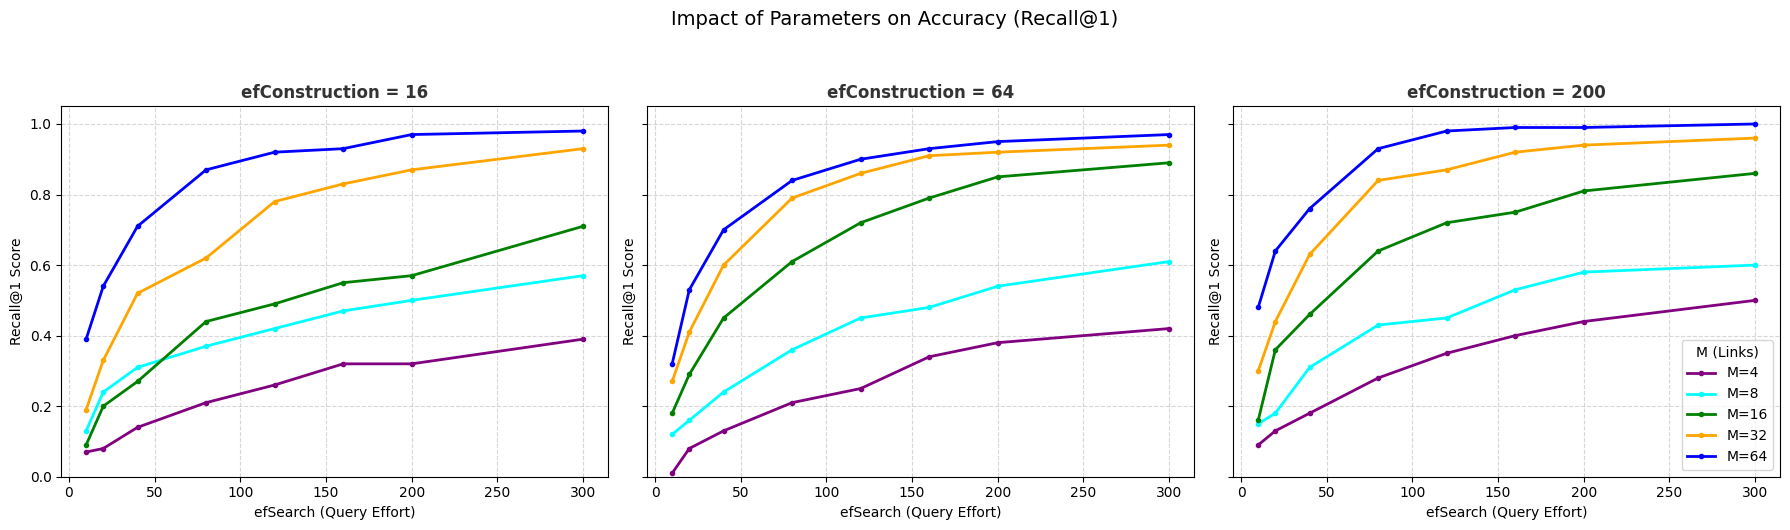

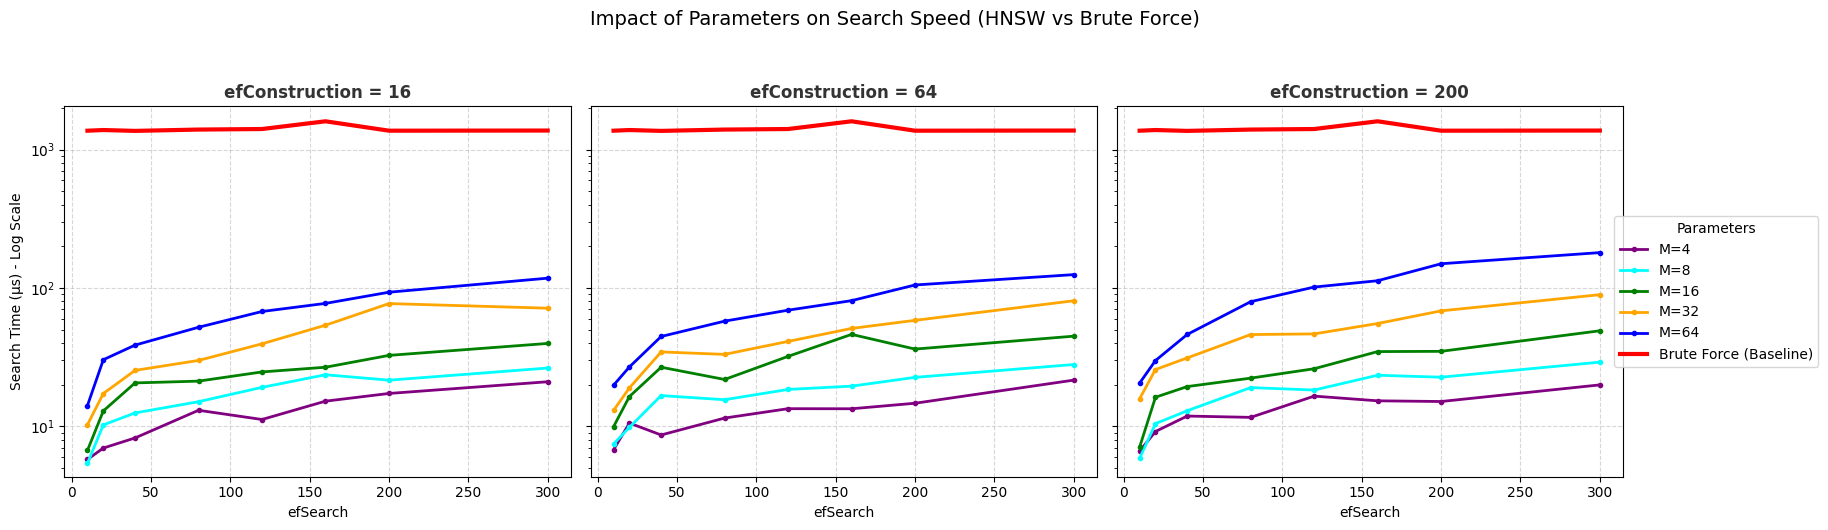

In [15]:
# --- PLOTTING: RECALL VS SPEED (DEEP DIVE) ---

# Re-define color map for consistency
M_values = [4, 8, 16, 32, 64]
efConst_values = [16, 64, 200]
colors = ['purple', 'cyan', 'green', 'orange', 'blue', 'red']
color_map = dict(zip(M_values, colors))


# --- PLOT 1: RECALL@1 VS efSEARCH ---
fig_recall, axes_recall = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, efConst in enumerate(efConst_values):
    ax = axes_recall[i]
    
    if efConst in experiment_results:
        for M in M_values:
            if M in experiment_results[efConst]:
                y_values = experiment_results[efConst][M]['recall']
                ax.plot(efSearch_values, y_values, marker='.', linewidth=2,
                        color=color_map.get(M, 'gray'), label=f'M={M}')

    ax.set_title(f'efConstruction = {efConst}', fontsize=12, fontweight='bold', color='#333')
    ax.set_xlabel('efSearch (Query Effort)')
    ax.set_ylabel('Recall@1 Score')
    ax.set_ylim(0, 1.05)
    ax.grid(True, linestyle='--', alpha=0.5)
    
    if i == 2: ax.legend(title='M (Links)', loc='lower right')

plt.suptitle("Impact of Parameters on Accuracy (Recall@1)", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

# --- PLOT 2: SEARCH TIME VS efSEARCH ---
fig_time, axes_time = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Calculate Y-axis scaling
all_times = []
bf_time_to_plot = []
for ef in experiment_results:
    for M in experiment_results[ef]:
        all_times.extend(experiment_results[ef][M]['hnsw_time'])
        # Grab one of the stored BF time lists (they should be nearly identical)
        if not bf_time_to_plot:
            bf_time_to_plot = experiment_results[ef][M]['bf_time']
        
y_min = min(all_times) * 0.8 if all_times else 10
y_max = max(max(all_times), bf_time_to_plot[0] if bf_time_to_plot else 2000) * 1.5 


for i, efConst in enumerate(efConst_values):
    ax = axes_time[i]
    
    # 1. Plot HNSW curves
    if efConst in experiment_results:
        for M in M_values:
            if M in experiment_results[efConst]:
                y_values = experiment_results[efConst][M]['hnsw_time']
                ax.plot(efSearch_values, y_values, marker='.', linewidth=2,
                        color=color_map.get(M, 'gray'), label=f'M={M}')

    # 2. Plot Brute Force Baseline (calculated line)
    if bf_time_to_plot:
        ax.plot(efSearch_values, bf_time_to_plot, color='red', linestyle='-', linewidth=3, label='Brute Force (Baseline)')

    # Styling
    ax.set_title(f'efConstruction = {efConst}', fontsize=12, fontweight='bold', color='#333')
    ax.set_xlabel('efSearch')
    ax.set_yscale('log')
    ax.set_ylim(y_min, y_max)
    ax.grid(True, linestyle='--', alpha=0.5)
    
    if i == 0: ax.set_ylabel('Search Time (µs) - Log Scale')
    if i == 2: 
        handles, labels = ax.get_legend_handles_labels()
        unique_labels = []
        unique_handles = []
        for h, l in zip(handles, labels):
            if l not in unique_labels:
                unique_labels.append(l)
                unique_handles.append(h)
        ax.legend(unique_handles, unique_labels, title='Parameters', loc='center right', bbox_to_anchor=(1.4, 0.5))

plt.suptitle("Impact of Parameters on Search Speed (HNSW vs Brute Force)", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

# 7. Simulated Graph Structure Analysis

Simulates and visualizes the hierarchical and connectivity structure of the HNSW graph.

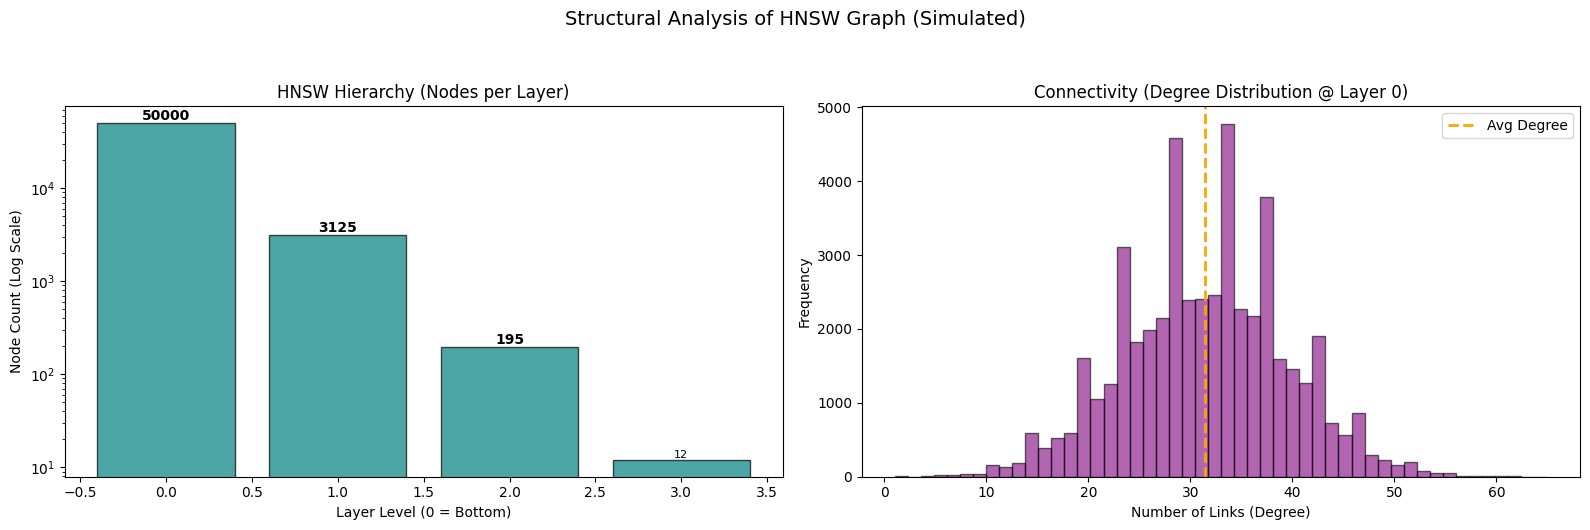

In [16]:
# --- GRAPH STRUCTURE ANALYSIS (Simulation) ---

def simulate_hnsw_structure(num_elements, M):
    """Simulates the layer and degree structure of the HNSW graph."""
    layers = []
    # Layer 0 (Bottom Layer): Contains all nodes
    deg_L0 = np.random.normal(loc=M*2, scale=M/2, size=num_elements).astype(int)
    deg_L0 = np.clip(deg_L0, 1, None) 
    layers.append(deg_L0)
    
    # Upper Layers: Node count decays exponentially (1/M)
    count = num_elements
    while count > M:
        count = int(count / M)
        if count == 0: break
        deg = np.random.normal(loc=M, scale=M/4, size=count).astype(int)
        layers.append(deg)
    return layers

# Generate mock data for M=16
mock_layers = simulate_hnsw_structure(NUM_ELEMENTS, 16)
node_counts = [len(l) for l in mock_layers]

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Hierarchy (Nodes per Layer)
ax1.bar(range(len(node_counts)), node_counts, color='teal', alpha=0.7, edgecolor='black')
ax1.set_yscale('log')
ax1.set_title('HNSW Hierarchy (Nodes per Layer)')
ax1.set_xlabel('Layer Level (0 = Bottom)')
ax1.set_ylabel('Node Count (Log Scale)')
for i, v in enumerate(node_counts):
    if v > 100:
        ax1.text(i, v, str(v), ha='center', va='bottom', fontweight='bold')
    else:
         ax1.text(i, v, str(v), ha='center', va='bottom', fontsize=8)


# Plot 2: Connectivity (Degree Distribution @ Layer 0)
ax2.hist(mock_layers[0], bins=50, color='purple', alpha=0.6, edgecolor='black')
ax2.axvline(np.mean(mock_layers[0]), color='orange', linestyle='--', linewidth=2, label='Avg Degree')
ax2.set_title('Connectivity (Degree Distribution @ Layer 0)')
ax2.set_xlabel('Number of Links (Degree)')
ax2.set_ylabel('Frequency')
ax2.legend()

plt.suptitle("Structural Analysis of HNSW Graph (Simulated)", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()